# Plot CNN segmentation metrics statistics

This notebook plots the training and validation data.
(for plotting test data use: src/postproc/MAIN_create_summary_plots_test_patches.py)

## Prepare all inputs

### ADJUST Input parameters

In [1]:
# ----------------- ADJUST INPUT PARAMETERS -----------------
PARAM = {}
PARAM['EPSG_TARGET'] = 32654
plot_width = 1200

# overfit threshold to find best two epochs
overfit_threshold = 0.1
metrics_decide = 'jacc_macro'

PARAM['CLASS_LABELS'] = [
        [0, 1, 2, 3, 4, 5, 6],
        ['nan', 'baydherakhs', 'ponding_areas', 'stable_areas',
         'gully_base', 'ponds', 'snow']]

# min and max epoch for overview boxplot stats
min_epoch = 15
max_epoch = 100

# if some folders should not be searched for results
exclude_folder = []

# folder name of CNN training results
# dictionary key is id_name_of_set from site_sets_dict,
#    value is the actual folder name
PARAM['SITES'] = {
    'BLyaE_v1_HEX1979_A02':
        'BLyaE_v1_HEX1979_A02',
    'BLyaE_v1_HEX1979_A02_v079t16_finet_FadN':
        'BLyaE_v1_HEX1979_A02_v079t16_finet_FadN',
    }

# if want to use all metrics fot plotting then this can be set to None
metrics_lst = [
    'acc_micro', 'dice_micro', 'f1_macro',
    'jacc_micro', 'jacc_macro',
    'precision_macro', 'recall_macro',
    'jacc_class01_baydherakhs', 'jacc_class02_ridges_ponds',
    'jacc_class03_stable_areas', 'jacc_class04_gully_base',
    'jacc_class05_ponds', 'jacc_class06_snow']

#### Load required modules

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import panel as pn
pn.extension()
from sidecar import Sidecar
import holoviews as hv
from holoviews import dim

hv.extension('bokeh', width=1000)

In [3]:
# --------- import custom utils ---------
PATH_MODULES = os.path.abspath(
    os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))

sys.path.insert(0, PATH_MODULES)
import utils.plotting_utils as plotting_utils
import postproc.postproc.model_comparison_plots as model_comparison_plots
import postproc.postproc.interactive_plotting_utils as interactive_plotting_utils

#### Define input paths

In [4]:
# !!!! THIS NEEDS TO BE ADJUSTED IF PROJECT PATH IS NOT IN MODULE DIRECTORY
# SINCE RELAITVE PATHS DO NOT WORK WELL IN JUPYTER NOTEBOOK
BASE_PATH = os.path.abspath(
    os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../'))
sys.path.insert(0, BASE_PATH)
import example.add_base_path
path_proj_inp, path_temp_inp = example.add_base_path.main()
MAIN_PATH_PROJ = os.path.abspath(os.path.join(BASE_PATH, path_proj_inp))

# project paths
PATH = os.path.join(MAIN_PATH_PROJ, '2_segment', '02_train')
PATH_INP = os.path.join(MAIN_PATH_PROJ, '2_segment', '01_input')
PATH_EXPORT = os.path.join(MAIN_PATH_PROJ, '2_segment', '03_analyse')

#### Read parameter files (PARAM_MERGE_ID and PARAM_TRAIN_ID sets)

In [5]:
path_inp = os.path.join(PATH_MODULES, 'param_settings', 'PARAM_inp_CNN_feature_prep_v01.txt')
PARAM_MERGE = pd.read_csv(
    path_inp, delimiter='\t', header=0, index_col=0)

path_inp = os.path.join(PATH_MODULES, 'param_settings', 'PARAM_inp_CNN_train_v01.txt')
PARAM_TRAIN = pd.read_csv(
    path_inp, delimiter='\t', header=0, index_col=0)


#### Find trained CNN models

In [6]:
# ----- Get DataFrame with all trained model setups
# TRAIN_INFO is a DataFRame that summarizes all trained setups
# that are available in the 02_train folder
TRAIN_INFO = model_comparison_plots.get_results_folder_DL(
    None, exclude_folder,
    PARAM['SITES'], PATH, PATH_EXPORT)

# -- Get counts of tested frameworks
count_merge_set = TRAIN_INFO.reset_index('folder').groupby(['site', 'merge_id']).count()
count_merge_set.index.rename({'merge_id': 'PARAM_PREP_ID'}, inplace=True)
count_train_set = TRAIN_INFO.reset_index('folder').groupby(['site', 'train_id']).count()
count_train_set['train_id_add'] = count_train_set.index.get_level_values(level='train_id')
count_train_set['PARAM_TRAIN_ID'] = count_train_set['train_id_add']
count_train_set = count_train_set.reset_index().set_index(['site', 'PARAM_TRAIN_ID'])

# -- Add counts of tested frameworks per site to parameter file
for i_key, i_folder in PARAM['SITES'].items():
    PARAM_MERGE['count_' + i_key] = 0
    PARAM_MERGE['count_' + i_key] = count_merge_set.loc[i_key, 'folder']

    PARAM_TRAIN['count_' + i_key] = 0
    PARAM_TRAIN['count_' + i_key] = count_train_set.loc[i_key, 'folder']

#### Read all train and validation metrics

In [7]:
# ---- Read all metrics files (.txt) and summarizes them in DataFrames
train_metrics_all, train_model_save_df, train_cm_df, train_classIoU_df = model_comparison_plots.extract_metrics_train_DL(
    TRAIN_INFO, PATH, PARAM['SITES'], slice(None), join_char_settings='\n')

# Extract dataframe that spcifies the epochs at which a model was saved
# (checkpoints, where model improvement occurd)
train_model_save_df_checkp = train_model_save_df.query('if_checkp == True')

#### Extract epochs to analyse

In [8]:
# in this option the last 50 epochs are used an not only the ones where a checkpoint was saved
# and also independent of overfit
# (for other epoch extractions see end of this notebook)
metrics_every_epoch = train_metrics_all.copy()
metrics_every_epoch.rename(columns={'train': 't', 'validate': 'v'}, level='phase', inplace=True)

grouped = metrics_every_epoch.loc[:, 'v'].groupby(['site', 'folder'], group_keys=False)
last50_epochs_all = grouped.apply(lambda x: x.reset_index('epoch').nlargest(50, columns='epoch')).set_index('epoch', append=True).sort_index()

index_extract = last50_epochs_all.index  # last 50 epochs from all
metrics_all_sel = metrics_every_epoch.loc[index_extract]
metrics_all_sel = metrics_all_sel.unstack('site').swaplevel(-1, 0,axis=1).swaplevel(-1, 1,axis=1).stack('phase',future_stack=True).swaplevel(-1, 1,axis=0).sort_index(axis=1).sort_index(axis=0)



-------


## Overview quality plot with all metrics

#### Extract site and settings for plotting

In [9]:
# extract sites and settings set
sites_lst = train_metrics_all.index.get_level_values(level='site').unique().tolist()
settings_lst = metrics_all_sel.index.get_level_values(level='settings').unique().tolist()
if metrics_lst is None:
    metrics_lst = metrics_all_sel.columns.get_level_values(level='metrics').unique().tolist()
sites_col = ['Blues', 'Oranges', 'Greys', 'Greens', 'Reds', 'Purples']
col_map01 = {}
col_name = {}
for e, i in enumerate(sites_lst):
    col_map01[i] = plotting_utils.cmap_to_hex(sites_col[e], num_bin=4)[1:]
    col_name[i] = sites_col[e]

#### Create interactive plot
(Select several sites or metrics with crtl)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
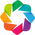

In [10]:
hv.extension('bokeh', width=plot_width)
param_box = dict(box_fill_color=dim('phase').str(), box_alpha=0.5)  # for hv.BoxWhisker
# param_violin = dict(violin_color=dim('phase').str(), box_alpha=0.5)  # for hv.Violin
# param_bar = dict(alpha=0.5)  # for hv.Bars
explorer_ocverview = interactive_plotting_utils.AdvancedMetricsExplorer(
    metrics_all_sel, sites_lst, metrics_lst, col_map01,
    hv.BoxWhisker, param_box,  PARAM_MERGE.copy(), PARAM_TRAIN.copy(), col_name, width=plot_width).servable()

sc = Sidecar(title='metrics boxlot')
with sc:
    display(explorer_ocverview)
#display(explorer_ocverview)

## Class IoU plot

#### Extract required data

In [11]:
metrics_all_sel_stack = metrics_all_sel.stack('site', future_stack=True)
m_col = [x for x in metrics_all_sel_stack.columns if x.find('jacc_class') > -1]
metrics_all_sel_stack = metrics_all_sel_stack.loc[:, m_col]
rename_dict = {x: x.split('jacc_class')[1] for x in m_col}
metrics_all_sel_stack = metrics_all_sel_stack.rename(rename_dict, axis=1).drop('00_nan', axis=1)
#metrics_all_sel_stack
metrics_all_sel_jacc = metrics_all_sel_stack.unstack('site').swaplevel(0, 1, axis=1).sort_index().stack('metrics', future_stack=True)

index_col1 = list(zip(metrics_all_sel_jacc.columns, ['val']*len(metrics_all_sel_jacc.columns)))
index_col = pd.MultiIndex.from_tuples(index_col1, names=['site', 'values'])
metrics_all_sel_jacc.columns = index_col

#### Create interactive plot
(Select several sites or metrics with crtl)

In [12]:
param_box = dict(box_fill_color=dim('phase').str(), box_alpha=0.5)  # for hv.BoxWhisker
explorer_ocverview_j = interactive_plotting_utils.AdvancedMetricsExplorerJacc(
    metrics_all_sel_jacc, sites_lst, col_map01, hv.BoxWhisker,
    param_box,  PARAM_MERGE.copy(), PARAM_TRAIN.copy(), col_name, width=plot_width, height=500, path_out=PATH).servable()

sc_j = Sidecar(title='metrics boxlot_Jacc')
with sc_j:
    display(explorer_ocverview_j)

In [13]:
train_classIoU_df

train  \
                                                                                                                                                     jacc_class00_nan   
site                                    settings   site_settings                                      cv_num folder          merge_id train_id epoch                    
BLyaE_v1_HEX1979_A02                    v079t16off BLyaE_v1_HEX1979_A02\nv079t16off                   cv00   v079t16off_cv00 v079     t16off   0                  0.0   
                                                                                                                                               1                  0.0   
                                                                                                                                               2                  0.0   
                                                                                                                                               3                  0.0   
                                                                                                                                               4                  0.0   
...                                                                                                                                                               ...   
BLyaE_v1_HEX1979_A02_v079t16_finet_FadN v079t16onl BLyaE_v1_HEX1979_A02_v079t16_finet_FadN\nv079t1... cv02   v079t16onl_cv02 v079     t16onl   45                 0.0   
                                                                                                                                               46                 0.0   
                                                                                                                                               47                 0.0   
                                                                                                                                               48                 0.0   
                                                                                                                                               49                 0.0   

                                                                                                                                                                               \
                                                                                                                                                     jacc_class01_baydherakhs   
site                                    settings   site_settings                                      cv_num folder          merge_id train_id epoch                            
BLyaE_v1_HEX1979_A02                    v079t16off BLyaE_v1_HEX1979_A02\nv079t16off                   cv00   v079t16off_cv00 v079     t16off   0                     0.025003   
                                                                                                                                               1                     0.000004   
                                                                                                                                               2                     0.061218   
                                                                                                                                               3                     0.087427   
                                                                                                                                               4                     0.156235   
...                                                                                                                                                                       ...   
BLyaE_v1_HEX1979_A02_v079t16_finet_FadN v079t16onl BLyaE_v1_HEX1979_A02_v079t16_finet_FadN\nv079t1... cv02   v079t16onl_cv02 v079     t16onl   45                    0.536311   
                       

## IoU learning curve

#### Extract required data

In [14]:
# extract IoU data
train_classIoU_df.columns.names = ['phase', 'metrics']
train_class_IoU_plot_df = train_classIoU_df.swaplevel(0, 1, axis=1).sort_index()

# extract sistes and settigns set
sites_lst = train_class_IoU_plot_df.index.get_level_values(level='site').unique().tolist()
settings_lst = train_class_IoU_plot_df.index.get_level_values(level='settings').unique().tolist()
class_lst = train_class_IoU_plot_df.columns.get_level_values(level='metrics').unique().tolist()
class_col = ['Blues', 'Oranges', 'Greys', 'Greens', 'Reds', 'Purples', 'RdPu', 'BuGn']

n_fact = int(np.ceil(len(sites_lst)/3)) + 1
dashes = ['solid', 'dashed', 'dotted'] * n_fact
line_w = [2, 2, 2] * n_fact
marker_w = ['circle', 'triangle', 'square'] * n_fact
col_map = {}
for e, i in enumerate(class_lst):
    col_map[i] = class_col[e]
line_dash = {}
line_width = {}
marker_type = {}
for e, i in enumerate(sites_lst):
    line_dash[i] = dashes[e]
    line_width[i] = line_w[e]
    marker_type[i] = marker_w[e]

train_class_IoU_plot_df = train_class_IoU_plot_df.reset_index().set_index(['site', 'folder', 'settings', 'site_settings', 'cv_num', 'merge_id', 'train_id', 'epoch'])

#### Create interactive plot
(Select several sites or metrics with crtl)

In [15]:
IoU_explorer = interactive_plotting_utils.AdvancedIoUCurveExplorer(
    train_class_IoU_plot_df, None, sites_lst, col_map, line_dash,
    line_width, marker_type, PARAM_MERGE.copy(), PARAM_TRAIN.copy(), width=plot_width,
    hight=1000).servable()

sc1 = Sidecar(title='class IoU')
with sc1:
    display(IoU_explorer)

## Other options to extract specific epochs and metrics

In [16]:
# extracts only epochs at checkpoints
metrics_all = train_metrics_all.loc[train_model_save_df_checkp.index]
metrics_all.columns.names = ['phase', 'metrics']
# query epochs within certain range
metrics_all = metrics_all.query('epoch >= @min_epoch and epoch <= @max_epoch')
metrics_all.rename(columns={'train': 't', 'validate': 'v'}, level='phase', inplace=True)

# add diff between train and validate to have an indication for overfit
epoch_diff = metrics_all.loc[:, 't'] - metrics_all.loc[:, 'v']

# check stats
epoch_diff.describe()

metrics,acc_all,acc_micro,acc_macro,acc_w,dice_micro,dice_macro,f1_macro,precision_macro,recall_macro,jacc_micro,jacc_macro,loss,jacc_class00_nan,jacc_class01_baydherakhs,jacc_class02_ridges_ponds,jacc_class03_stable_areas,jacc_class04_gully_base,jacc_class05_ponds,jacc_class06_snow
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.0,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,0.022704,0.035611,0.023640,0.035611,0.028250,0.042446,0.044853,0.047326,0.023640,0.052680,0.051310,-0.113896,0.0,0.069838,0.113365,0.034092,0.058451,-0.004578,0.036691
std,0.049838,0.058090,0.056912,0.058090,0.053411,0.043794,0.044851,0.052572,0.056912,0.086222,0.051720,0.174638,0.0,0.093692,0.170512,0.062983,0.150155,0.062037,0.114663
min,-0.067754,-0.064039,-0.103560,-0.064039,-0.060661,-0.069785,-0.069285,-0.080619,-0.103560,-0.093959,-0.079157,-0.635229,0.0,-0.143684,-0.235006,-0.053417,-0.186574,-0.167179,-0.286985
25%,-0.017692,-0.011737,-0.010558,-0.011737,-0.013915,0.014547,0.015657,0.021446,-0.010558,-0.018187,0.021647,-0.220147,0.0,0.004420,-0.000860,-0.018579,-0.078574,-0.046372,0.000000
50%,0.009152,0.013974,0.020382,0.013974,0.011194,0.038096,0.039540,0.042792,0.020382,0.022062,0.048521,-0.057376,0.0,0.059743,0.064360,-0.001602,0.021524,-0.000494,0.013511
75%,0.068706,0.091247,0.057260,0.091247,0.076330,0.070434,0.071960,0.074082,0.057260,0.127017,0.074393,0.020615,0.0,0.112726,0.215738,0.096962,0.215336,0.044475,0.097275
max,0.124196,0.153877,0.165962,0.153877,0.137456,0.149063,0.172241,0.265989,0.165962,0.236130,0.178887,0.149545,0.0,0.298203,0.551973,0.158643,0.291933,0.120514,0.356055


In [17]:
# derive two epochs with minimium overfit
grouped = epoch_diff.groupby(['site', 'settings'], group_keys=False)
epoch_min_overfit = grouped.apply(lambda x: x.nsmallest(2, columns=metrics_decide)).sort_index()

# get epochs with two best metrics but below overfit threshold
metrics_valid = metrics_all.loc[:, 'v'].copy()
metrics_valid[metrics_decide + '_diff'] = epoch_diff[metrics_decide]
grouped = metrics_valid.groupby(['site', 'folder'], group_keys=False)
epoch_best_two = grouped.apply(lambda x: (x.loc[x[metrics_decide + '_diff'] < overfit_threshold, :]).nlargest(2, columns=metrics_decide)).sort_index()
epoch_best_two.head()

# to use best epoch but below overfit threshold
grouped = metrics_valid.groupby(['site', 'folder'], group_keys=False)
# epoch_min_overfit = grouped.apply(lambda x: (x.loc[x.index.get_level_values(level='epoch') > 10]).nsmallest(2, columns=metrics_decide))
epoch_best = grouped.apply(lambda x: (x.loc[x[metrics_decide + '_diff'] < overfit_threshold, :]).nlargest(1, columns=metrics_decide)).sort_index()

# to use just the latest two epochs
grouped = metrics_all.loc[:, 'v'].groupby(['site', 'folder'], group_keys=False)
epoch_last_two = grouped.apply(lambda x: x.reset_index('epoch').nlargest(2, columns='epoch')).set_index('epoch', append=True).sort_index()

# to aggregate epoch as lists and count how many epochs:
all_epochs = metrics_all.loc[:, 'v'].reset_index('epoch').groupby(['site', 'folder']).agg(epoch_count=('epoch','count'), epoch_lst=('epoch', list))
# all_epochs.epoch_count.min()

In [18]:

# get metrics of best validation accuracies and below overfit threshold
metrics_best = metrics_all.loc[epoch_best.index].unstack('site').swaplevel(-1, 0,axis=1).swaplevel(-1, 1,axis=1).stack('phase', future_stack=True).swaplevel(-1, 1,axis=0).sort_index(axis=1).sort_index(axis=0)
